###  Author : 
#### (Cris) Jiangyang Liu

## Case study 1

#### First get the fips country code of OPEC countries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline

In [2]:
a = pd.read_clipboard(sep='\t')
# copy past from http://download.geonames.org/export/dump/countryInfo.txt

In [4]:
opec_country = ['Algeria', 'Angola', 'Ecuador', 'Gabon', 
                'Indonesia', 'Iran', 'Iraq', 'Kuwait', 'Libya', 
                'Nigeria', 'Qatar', 'Saudi Arabia', 
                'UAE', 'Venezuela']

In [14]:
opec_fips = pd.merge(pd.DataFrame(opec_country,columns=['name']),a[['Country','fips']],
         how='left',left_on='name',right_on='Country').drop('Country',1)

In [15]:
opec_fips

,name,fips
0,Algeria,AG
1,Angola,AO
2,Ecuador,EC
3,Gabon,GB
4,Indonesia,ID
5,Iran,IR
6,Iraq,IZ
7,Kuwait,KU
8,Libya,LY
9,Nigeria,NI


In [17]:
opec_fips.fips.values
# Impute UAE to 'AE'

array(['AG', 'AO', 'EC', 'GB', 'ID', 'IR', 'IZ', 'KU', 'LY', 'NI', 'QA',
       'SA', nan, 'VE'], dtype=object)

#### Then apply it on the Google Bigquery 

In [ ]:
select ActionGeo_CountryCode,MonthYear,count(*) as country_month_ct,
from [gdelt-bq:gdeltv2.events]
where SQLDATE >= 20140901 and SQLDATE <= 20170930 and QuadClass in (3,4)
and ActionGeo_CountryCode in ('AG', 'AO', 'EC', 'GB', 'ID', 'IR', 'IZ', 'KU', 'LY', 'NI', 'QA',
       'SA', 'AE', 'VE')
group by MonthYear,ActionGeo_CountryCode
order by ActionGeo_CountryCode,MonthYear

Pull the number of conflicts by country and Month

In [2]:
opec_conflicts = pd.read_csv('Downloads/results-20171014-115340.csv')

opec_conflicts.head(5)

,ActionGeo_CountryCode,MonthYear,country_month_ct
0,AE,201409,45
1,AE,201410,50
2,AE,201411,77
3,AE,201412,65
4,AE,201501,79


We also pull total number of conflicts in the world during same time window, so to normalize the counts above. 

In [3]:
#Bigquery
select MonthYear,count(*) as total_month_ct,
from [gdelt-bq:gdeltv2.events]
where SQLDATE >= 20140901 and SQLDATE <= 20170930 and QuadClass in (3,4)
group by MonthYear
order by MonthYear

SyntaxError: invalid syntax (<ipython-input-3-8b433404b8d7>, line 2)

In [4]:
total_conflicts = pd.read_csv('Downloads/results-20171014-120040.csv')
total_conflicts.MonthYear = pd.to_datetime(total_conflicts.MonthYear.apply(lambda x:str(x*100+1)))
total_conflicts.set_index('MonthYear',inplace=True)
total_conflicts.head(5)

,total_month_ct
MonthYear,
2014-09-01,20465
2014-10-01,21332
2014-11-01,20989
2014-12-01,21051
2015-01-01,31587


As we expect, # of events increase due to various reasons, probably including explosion of media. So it is important to normalize the raw count!

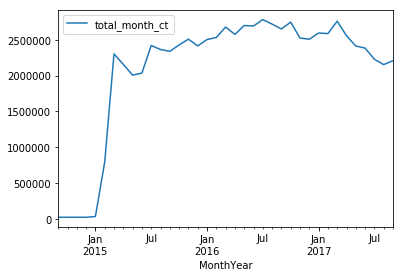

In [5]:
total_conflicts.plot()

Normailization

In [6]:
norm_opec_conflicts = pd.merge(opec_conflicts,total_conflicts,left_on='MonthYear',right_index=True,how='left')
norm_opec_conflicts['norm_month_ct'] = norm_opec_conflicts.country_month_ct / norm_opec_conflicts.total_month_ct*1000
norm_opec_conflicts.MonthYear = pd.to_datetime(norm_opec_conflicts.MonthYear.apply(lambda x:str(x*100+1)))
norm_opec_conflicts.set_index('MonthYear',inplace=True)
norm_opec_conflicts.head()

,ActionGeo_CountryCode,country_month_ct,total_month_ct,norm_month_ct
MonthYear,,,,
2014-09-01,AE,45,NaN,NaN
2014-10-01,AE,50,NaN,NaN
2014-11-01,AE,77,NaN,NaN
2014-12-01,AE,65,NaN,NaN
2015-01-01,AE,79,NaN,NaN


In [7]:
rolling_mean = pd.rolling_mean(norm_opec_conflicts.groupby('ActionGeo_CountryCode').norm_month_ct,3)
rolling_std = pd.rolling_std(norm_opec_conflicts.groupby('ActionGeo_CountryCode').norm_month_ct,3)

/Users/crisliu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for SeriesGroupBy and will be removed in a future version, replace with 
	SeriesGroupBy.rolling(center=False,window=3).mean()
  if __name__ == '__main__':
/Users/crisliu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_std is deprecated for SeriesGroupBy and will be removed in a future version, replace with 
	SeriesGroupBy.rolling(center=False,window=3).std()
  from ipykernel import kernelapp as app


In [8]:
current_count = norm_opec_conflicts.reset_index().set_index(['ActionGeo_CountryCode','MonthYear']).norm_month_ct

Compare current count to rolling mean and rolling std. If it goes up to the threshold, then we consider it as early sign of arising conflict

In [9]:
combine = pd.concat([current_count,rolling_mean,rolling_std],1)
combine.columns = [['current_count','rolling_mean','rolling_std']]
combine['arising_conflict_flag'] = combine.current_count >combine.rolling_mean + 1.15*combine.rolling_std

For example, for UAE, there are 3 times of arising conflict during Sep. 2014 to Sep. 2017

Empty DataFrame
Columns: [current_count, rolling_mean, rolling_std, arising_conflict_flag]
Index: []


/Users/crisliu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


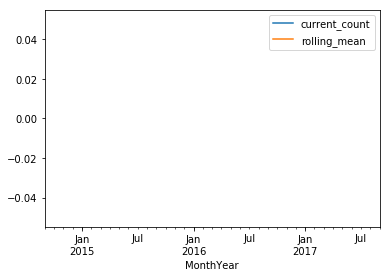

In [10]:
combine.ix['AE',:][['current_count','rolling_mean']].plot()
print(combine.ix['AE',:].query("arising_conflict_flag==1"))

#### Further study to do:

- We can do similar analysis for each country/region we are interested in
- We can run similar analysis on the DAY LEVEL, which the early sign will be more on-time
- We can tune the parameters and threshold further. 
- The current analysis is of post-hoc type. We can create application on real time, by using the same algorithm ( comparing current # of conflicts with rolling mean and standard), so it can raise flag in real time.

## Case Study 2

First bigquery, filter by time and theme = 'ENV_OIL'

In [ ]:
### Bigquery
SELECT GKGRECORDID, Persons,
REGEXP_EXTRACT(SPLIT(V2Locations,';'),r'^[2-5]#.*?#(.*?)#') as country
FROM [gdelt-bq:gdeltv2.gkg] 
WHERE DATE>=20140901000000 and DATE < 20171001000000 and Themes like '%ENV_OIL%'
and Persons is not null and Locations is not null
#save as [secret-energy-96715:mydata1.gkg_1]

Second bigquery, filter by OPEC country and split persons name

In [ ]:
### Bigquery
SELECT GKGRECORDID ,SPLIT(Persons,';') name, country
FROM
[secret-energy-96715:mydata1.gkg_1]
where country in ('AG', 'AO', 'EC', 'GB', 'ID', 'IR', 'IZ', 'KU', 'LY', 'NI', 'QA',
       'SA', 'AE', 'VE')
#save as [secret-energy-96715:mydata1.gkg_2]

In [ ]:
### Bigquery
select country,count(*) ct from [secret-energy-96715:mydata1.gkg_2]
group by country 
order by ct desc

In [144]:
pd.read_csv('Downloads/results-20171014-132336.csv')

,country,ct
0,NI,11444059
1,IR,9202447
2,IZ,7874564
3,SA,5330003
4,AE,4470350
5,VE,2869310
6,ID,2441682
7,LY,2374866
8,QA,1961032
9,AO,1679241


Pull data for network analysis

Here we pull the network in Gabon

In [188]:
### Bigquery
SELECT a.name as source, b.name as target, COUNT(*) as count
FROM (select * from [secret-energy-96715:mydata1.gkg_2] where country = 'GB')  a
JOIN EACH (select * from [secret-energy-96715:mydata1.gkg_2] where country = 'GB') b
ON a.GKGRECORDID=b.GKGRECORDID
WHERE a.name<b.name
GROUP EACH BY 1,2
ORDER BY 3 DESC
LIMIT 500

SyntaxError: invalid syntax (<ipython-input-188-e6e88ba94788>, line 2)

Use networkx to run pagerank, in which people with highest indicates highest influence power

In [146]:
import networkx as nx

In [155]:
a = pd.read_csv('Downloads/results-20171014-133106.csv',header=None,skiprows=1)
a.to_csv('Downloads/results-20171014-133106_2.csv',header=None,index=False)

In [158]:
G = nx.read_weighted_edgelist('Downloads/results-20171014-133106_2.csv',delimiter=',')

In [187]:
pr = nx.pagerank(G, alpha=0.95)
result = pd.DataFrame.from_dict(pr,orient='index')
result.columns = [['PageRank']]
result.sort_values(by='PageRank',ascending=False).head(10)

,PageRank
ali bongo,0.036787
jean ping,0.028965
omar bongo,0.028062
ali bongo ondimba,0.022829
republique gabonaise,0.021187
edward ondimba,0.019069
franois ntoutoume essonne,0.018970
yvon serge,0.018877
pacome moubelet boubeya,0.018363
august mboumba kombila,0.017623


We can see people with highest influence power in Gabon are:

- ali bongo
- jean ping
- omar bongo
- ali bongo ondimba	
- republique gabonaise

#### Further study to do:

- We can run similar analysis for each country/region we are interested in
- We can tune the alpha further in pagerank
- We can use Gephi for network visualization
- We can also use other network metrics other than pagerank: betweenness ,degree, closeness, etc.


One gephi example:
Influence power is ranked by darkness of color

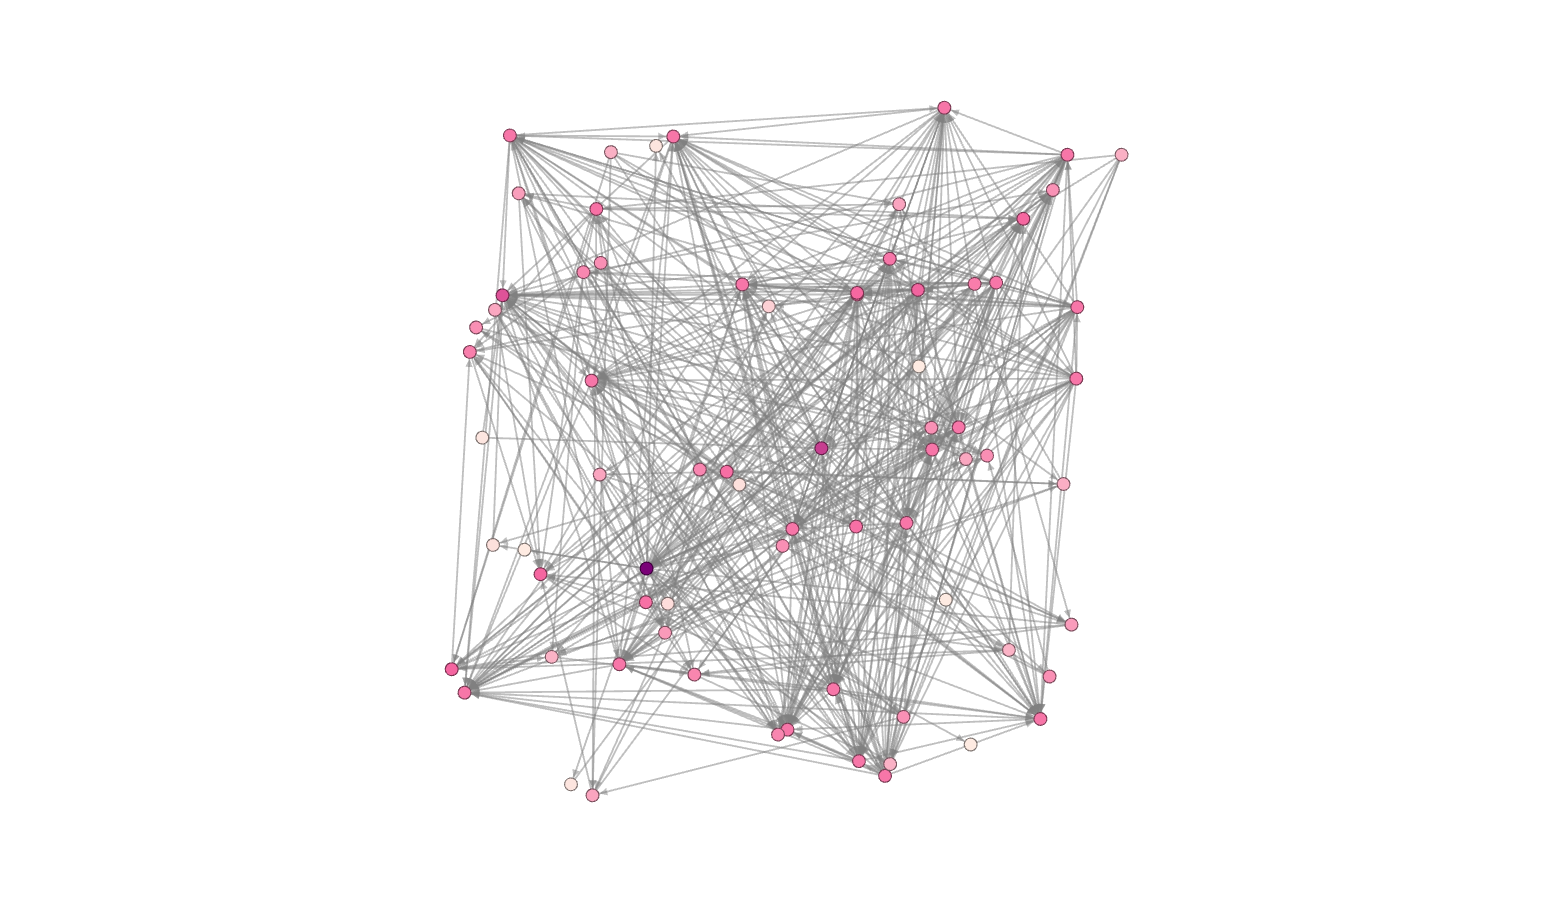

In [194]:
from IPython.display import Image
Image(filename="Downloads/Screen Shot 2017-10-14 at 14.01.55.png") 

## Case Study 3

Get opec-oil price from 
https://www.quandl.com/collections/markets/crude-oil

In [249]:
opec_price = pd.read_csv('Downloads/OPEC-ORB.csv',parse_dates=True)#.set_index('Date').sort_index()
opec_price.Date = pd.to_datetime(opec_price.Date)
opec_price = opec_price.set_index('Date').sort_index()
opec_price.head()

,Value
Date,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


Pull daily conflict event from OPEC countries

In [ ]:
select ActionGeo_CountryCode,SQLDATE,count(*) as country_month_ct,
from [gdelt-bq:gdeltv2.events]
where SQLDATE >= 20140901 and SQLDATE <= 20170930 and QuadClass in (3,4)
and ActionGeo_CountryCode in ('AG', 'AO', 'EC', 'GB', 'ID', 'IR', 'IZ', 'KU', 'LY', 'NI', 'QA',
       'SA', 'AE', 'VE')
group by SQLDATE,ActionGeo_CountryCode
order by ActionGeo_CountryCode,SQLDATE


In [206]:
daily_event = pd.read_csv('Downloads/results-20171014-141033.csv',parse_dates=True).set_index('SQLDATE')
daily_event.head()

,ActionGeo_CountryCode,country_month_ct
SQLDATE,,
20140904,AE,1
20140906,AE,4
20140907,AE,4
20140908,AE,6
20140909,AE,7


In [280]:
# Total # of events

In [ ]:
select SQLDATE,count(*) as total_month_ct,
from [gdelt-bq:gdeltv2.events]
where SQLDATE >= 20140901 and SQLDATE <= 20170930 and QuadClass in (3,4)
group by SQLDATE
order by SQLDATE


In [208]:
total_event = pd.read_csv('Downloads/results-20171014-141543.csv',parse_dates=True).set_index('SQLDATE')
total_event.head()

,total_month_ct
SQLDATE,
20140901,905
20140902,880
20140903,726
20140904,713
20140905,421


In [237]:
norm_opec_conflicts = pd.merge(daily_event,total_event,left_index=True,right_index=True,how='left')
norm_opec_conflicts['norm_month_ct'] = norm_opec_conflicts.country_month_ct / norm_opec_conflicts.total_month_ct*1000
norm_opec_conflicts = norm_opec_conflicts.reset_index()
norm_opec_conflicts.SQLDATE = pd.to_datetime(norm_opec_conflicts.SQLDATE.apply(lambda x:str(x)))
norm_opec_conflicts = norm_opec_conflicts.set_index('SQLDATE')
norm_opec_conflicts.head()

,ActionGeo_CountryCode,country_month_ct,total_month_ct,norm_month_ct
SQLDATE,,,,
2014-09-01,EC,3,905,3.314917
2014-09-01,ID,2,905,2.209945
2014-09-01,IR,12,905,13.259669
2014-09-01,IZ,14,905,15.469613
2014-09-01,LY,6,905,6.629834


In [238]:
rolling_mean = pd.rolling_mean(norm_opec_conflicts.groupby('ActionGeo_CountryCode').norm_month_ct,3)
rolling_std = pd.rolling_std(norm_opec_conflicts.groupby('ActionGeo_CountryCode').norm_month_ct,3)
current_count = norm_opec_conflicts.reset_index().set_index(['ActionGeo_CountryCode','SQLDATE']).norm_month_ct
combine = pd.concat([current_count,rolling_mean,rolling_std],1)
combine.columns = [['current_count','rolling_mean','rolling_std']]
combine['arising_conflict_flag'] = combine.current_count >combine.rolling_mean + 1.15*combine.rolling_std

/Users/crisliu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for SeriesGroupBy and will be removed in a future version, replace with 
	SeriesGroupBy.rolling(center=False,window=3).mean()
  if __name__ == '__main__':
/Users/crisliu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_std is deprecated for SeriesGroupBy and will be removed in a future version, replace with 
	SeriesGroupBy.rolling(center=False,window=3).std()
  from ipykernel import kernelapp as app


In [239]:
#combine['arising_conflict_flag'].sum()

624

In [268]:
opec_price['price_change'] = opec_price.diff(1)/opec_price

In [269]:
combine2 = pd.merge(combine.reset_index(),opec_price,left_on='SQLDATE',right_index=True,how='left')
combine2.head()

,ActionGeo_CountryCode,SQLDATE,current_count,rolling_mean,rolling_std,arising_conflict_flag,Value,price_change
0,AE,2014-09-04,1.402525,NaN,NaN,False,99.15,0.004942
1,AE,2014-09-06,10.610080,NaN,NaN,False,NaN,NaN
2,AE,2014-09-07,5.805515,5.939373,4.605237,False,NaN,NaN
3,AE,2014-09-08,7.792208,8.069268,2.414235,False,97.00,-0.014227
4,AE,2014-09-09,7.478632,7.025452,1.068067,False,96.99,-0.000103


In [270]:
combine2.groupby('arising_conflict_flag').price_change.describe()

,count,mean,std,min,25%,50%,75%,max
arising_conflict_flag,,,,,,,,
False,10165.0,-0.000715,0.020746,-0.092557,-0.013152,-0.001136,0.009795,0.102353
True,344.0,0.000152,0.021495,-0.092557,-0.011385,-0.000305,0.010723,0.068194


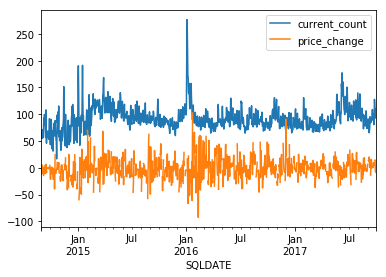

In [278]:
#Aggregated all the country
b = combine2.groupby('SQLDATE').current_count.sum()
c = combine2.groupby('SQLDATE').price_change.max()*1000
combine3 = pd.concat([b,c],1)
combine3.plot()

In [279]:
combine3.corr()

,current_count,price_change
current_count,1.000000,-0.035597
price_change,-0.035597,1.000000


#### Further study to do:

- We can test different number days as lags, to see how prompt that oil price react to conflict event
- Mesaure correlation of price change and event count change
- Mesaure correlation of VARIANCE of price change and event count change 
- Perform analysis on country level and quantify the impact of oil price for each country

### Thanks for reading!!